### Download datasets for this model here:

* https://drive.google.com/drive/folders/19TuTEOKfSOWr4IVf9PrTnN2TQiogoyYV?usp=sharing 

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score


import warnings
warnings.filterwarnings("ignore")

 ### Here we deifne how to tansform the the data to fit our models
 
 * With the torchvision transformer function
 * We will randomly flip images horisontally for Data augmentaion with we hope to imporve our accuracy
 * We then transform the dataset into a Tensor.
 * Therafter normalize the data.

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#### We also have a transform function for our validation set

In [3]:
valid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

### We define the training and test sets.

* Here we tell torchvision where the data is, then we load in the data with the DataLoader function
* we also split the data into a training set and a test set by using the train perameters, True or false

In [6]:
dataset = torchvision.datasets.CIFAR10(root='datasets/', download=True, transform=ToTensor())

train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

validation_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=valid_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64,
                                          shuffle=False, num_workers=4)




Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Here we import the Pyplot to assess if the images are loaded correctly or not.

* Importing matplotlip and numpy.
* We define a function to show images from the train_loader dataset
* We create a grid with torchvision and imbed the images into the grid.

In [7]:
len(validation_set), len(test_set), len(train_set)

(10000, 10000, 50000)

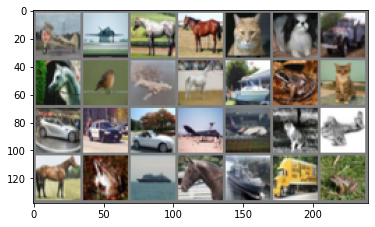

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:28], nrow=7))

### Check how many images the training and testing datasets contain

In [9]:
dataset_size = len(train_set)
test_dataset_size = len(test_set)

print("Training dataset size", dataset_size)
print("Testing datasets size", test_dataset_size)

print(dataset)


Training dataset size 50000
Testing datasets size 10000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()


### Get the classes of the entire dataset

In [10]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Get the Shapes of the images

In [11]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

### Print a sample image

Label (numeric): 6
Label (textual): frog


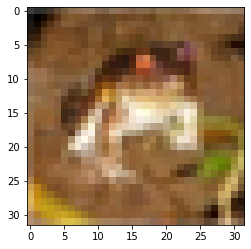

In [12]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

### Here we determine the number of images belonging to each class?

* We define the length of the dataset
* We then check hoe many classes there are
* We create a dictionary to store the values
* we then do 2 for loops, first to get the classes and the second to count the amount of images retaining to the classes 

In [13]:
dataset_size = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
    
for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


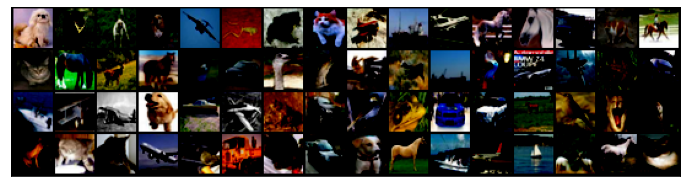

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

### Here we are creating the functionality for calculating the models accuracy

* Todo = Find out how this function works

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### ImageClassificationBase contains 4 functions
* One function is for training and validation sets, which implement the loss and accuracy.
* The validation_epoch_end combines the losses and accuracy for each epock 
* The epoch_end prints the val_lass and val_acc at the end of each epoch

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

##### nn.Sequential chains the layres and activation functions into a single network architecture

In [17]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [18]:
print(Cifar10CnnModel)

<class '__main__.Cifar10CnnModel'>


### Here we move our model to GPU if it can run it

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print("Model will run on, GPU")
        return torch.device('cuda')
    else:
        print("Model will run on, CPU")
        return torch.device('cpu')


In [20]:
device = get_default_device()
device

Model will run on, GPU


device(type='cuda')

#### Here we load the data into the GPU device

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [23]:
ourmodel = Cifar10CnnModel()
ourmodel

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [24]:
ourmodel = to_device(ourmodel, device)

### The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

In [25]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
history = [evaluate(ourmodel, validation_loader)]
history

[{'val_acc': 0.09952229261398315, 'val_loss': 2.3029160499572754}]

### Here we define the input and output size

In [27]:
input_size = 3*32*32
output_size = 10

### Number of epochs to cycle through and the learning rate is set here

In [28]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

### The fit function will record validation loss and metrics for each epoch

In [29]:
history += fit(num_epochs, lr, ourmodel, train_loader, validation_loader, opt_func)

Epoch [0], train_loss: 1.5997, val_loss: 1.2461, val_acc: 0.5334
Epoch [1], train_loss: 1.0511, val_loss: 0.9175, val_acc: 0.6805
Epoch [2], train_loss: 0.8136, val_loss: 0.8358, val_acc: 0.7092
Epoch [3], train_loss: 0.6795, val_loss: 0.7738, val_acc: 0.7370
Epoch [4], train_loss: 0.5875, val_loss: 0.6673, val_acc: 0.7726
Epoch [5], train_loss: 0.5180, val_loss: 0.6561, val_acc: 0.7749
Epoch [6], train_loss: 0.4610, val_loss: 0.6416, val_acc: 0.7844
Epoch [7], train_loss: 0.4140, val_loss: 0.6030, val_acc: 0.8047
Epoch [8], train_loss: 0.3799, val_loss: 0.6185, val_acc: 0.8081
Epoch [9], train_loss: 0.3365, val_loss: 0.6464, val_acc: 0.8017


In [30]:
from torchvision import models
alexnet = models.alexnet(pretrained=True)

In [31]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
import torch.nn as nn
# We need to change the classifiers to fit to the cifar 10 dataset
alexnet.classifier[4] = nn.Linear(4096,1024)
alexnet.classifier[6] = nn.Linear(1024,10)

#  since the Alexnet has 1000 nodesat the output layer this must be changed to 10 i.e. the number of classes we have
# model.classifier[6] = nn.Sequential(
#                       nn.Linear(256*4*4, 1024), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.4),
#                       nn.Linear(1024, 512),                   
#                       nn.LogSoftmax(dim=1))

# model.classifier[6] = nn.Sequential(
#                       nn.Flatten(), 
#                       nn.Linear(256*4*4, 1024),
#                       nn.ReLU(), 
#                       nn.Dropout(0.4),
#                       nn.Linear(1024, 512),
#                       nn.ReLU(),
#                       nn.Linear(512, 10),
#                       nn.LogSoftmax(dim=1))
# Add on classifier
# model.classifier[6] = nn.Sequential(
#             nn.Flatten(), 
#             nn.Linear(256*4*4, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10))

In [33]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [34]:
total_params = sum(p.numel() for p in alexnet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in alexnet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

44,428,106 total parameters.
44,428,106 training parameters.


In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        gpu_count = cuda.device_count()
        print(f'Model will run on GPU, {gpu_count} gpus detected.')
        if gpu_count > 1:
            multi_gpu = True
        else:
            multi_gpu = False
        return torch.device('cuda')
    else:
        print("Model will run on, CPU")
        return torch.device('cpu')

In [36]:
device = get_default_device()
device

NameError: ignored

In [37]:
# Move to gpu
alexnet = alexnet.to('cuda')
# Distribute across 2 gpus
# model = nn.DataParallel(model)

In [38]:
from torch import optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

In [40]:
transfer_models_trandorm = transforms.Compose([
    # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    # transforms.RandomRotation(degrees=15),
    # transforms.ColorJitter(),
    # transforms.RandomHorizontalFlip(),
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),  # Image net standards
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])  # Imagenet standards
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [41]:
transfer_valid_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [43]:
dataset = torchvision.datasets.CIFAR10(root='datasets/', download=True, transform=ToTensor())

train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transfer_models_trandorm)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transfer_models_trandorm)

validation_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transfer_valid_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64,
                                          shuffle=False, num_workers=4)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = alexnet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training of AlexNet')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Finished Training of AlexNet


In [46]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

resnet = ResNet(ResidualBlock, [2, 2, 2]).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)


# Save the model checkpoint
torch.save(resnet.state_dict(), 'resnet.ckpt')

RuntimeError: ignored

In [47]:
def plot_matrix (confusion_matrix):
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
    plt.ylabel('Actual Category')
    plt.yticks(range(10), classes)
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), classes)
    plt.show()

In [48]:
def print_matrix (confusion_matrix):
    print('actual/pred'.ljust(16), end='')
    for i,c in enumerate(classes):
        print(c.ljust(10), end='')
    print()
    for i,r in enumerate(confusion_matrix):
        print(classes[i].ljust(16), end='')
        for idx, p in enumerate(r):
            print(str(p).ljust(10), end='')
        print()
        r = r/np.sum(r)
        print(''.ljust(16), end='')
        for idx, p in enumerate(r):
            print(str(p).ljust(10), end='')
        print()

In [49]:
def prf1(confusion_matrix):
    TP = 0
    FP = 0
    FN = 0

    for i,r in enumerate(confusion_matrix):
        total = 0
        thisTP = 0
        thisFN = 0
        thisFP = 0 
        for i3 in range (0,10):
            if (i != i3):
                thisFP += confusion_matrix[i3][i]
        for i2,r2 in enumerate(r):
            total += r2
            if (i == i2):
                thisTP += r2
            else:
                thisFN += r2

        print(classes[i])
        print('True positives %d' % (thisTP))
        print('False positives %d' % (thisFP))
        print('False negatives %d' % (thisFN))
        precision = thisTP / (thisTP + thisFP)
        recall = thisTP / (thisTP + thisFN)
        print('Precicion {}'.format(precision))
        print('Recall {}'.format(recall))
        f1 = (2 * (precision*recall)) / (precision + recall)
        print('F1 {}'.format(f1))

In [50]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs'); 

In [51]:
def plot_losses_epochs(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    

In [52]:
def test_model(model):    
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    y_actual = []
    y_pred = []
    confusion_matrix = np.zeros([10,10], int)

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                correct_pred[label] += c[i].item()
                total_pred[label] += 1
            for i, l in enumerate(labels):
                y_actual.append(l.item())
                y_pred.append(predicted[i].item())
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    return correct_pred, total_pred, y_actual, y_pred, confusion_matrix

### Our model

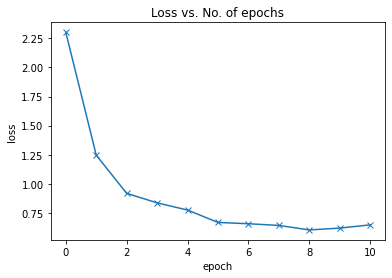

In [53]:
plot_losses(history)

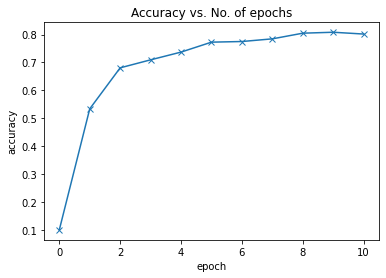

In [54]:
plot_accuracies(history)

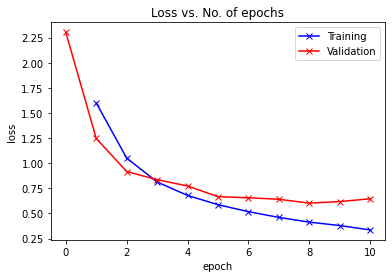

In [55]:
plot_losses_epochs(history);

In [56]:
correct_pred, total_pred, y_actual, y_pred, confusion_matrix = test_model(ourmodel)

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

RuntimeError: ignored

In [ ]:
matthews_corrcoef(y_actual, y_pred)

In [ ]:
classification_report(y_actual, y_pred, target_names=classes)

In [ ]:
cohen_kappa_score(y_actual, y_pred)

### AlexNet 


In [57]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 89 %


In [58]:
correct_pred, total_pred, y_actual, y_pred, confusion_matrix = test_model(alexnet)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * correct_pred[i] / total_pred[i]))

KeyError: ignored

In [ ]:
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

In [ ]:
matthews_corrcoef(y_actual, y_pred)

In [ ]:
classification_report(y_actual, y_pred, target_names=classes)

In [ ]:
cohen_kappa_score(y_actual, y_pred)

### Resnet


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(resnet.state_dict(), 'resnet.ckpt')

In [ ]:
correct_pred, total_pred, y_actual, y_pred, confusion_matrix = test_model(resnet)


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * correct_pred[i] / total_pred[i]))

In [ ]:
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

In [ ]:
matthews_corrcoef(y_actual, y_pred)

In [ ]:
classification_report(y_actual, y_pred, target_names=classes)

In [ ]:
cohen_kappa_score(y_actual, y_pred)